In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
xmin = -0.5
xmax = 1
ymin = -0.5
ymax = 1.5
N = 50
Re = 100
nu = 1 / Re
lamb = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

In [3]:
x_data = np.arange(xmin, xmax, (xmax-xmin)/N)
y_data = np.arange(ymin, ymax, (ymax-ymin)/N)

#print("X_data: ", x_data)
#print("Y_data: ", y_data)

x = []
y = []
for i in range(N):
    x.append(xmin)
    y.append(y_data[i])
    x.append(xmax)
    y.append(y_data[i])
    x.append(x_data[i])
    y.append(ymin)
    x.append(x_data[i])
    y.append(ymax)

x = np.array(x, dtype=float)
y = np.array(y, dtype=float)
X_bc = np.ndarray.reshape(x, (x.shape[0],1))
Y_bc = np.ndarray.reshape(y, (y.shape[0],1))

S_bc = np.zeros((4*N, 3))
U_bc = 1-(np.exp(lamb*X_bc))*(np.cos(2*math.pi*Y_bc))
V_bc = (lamb/(2*math.pi))*(np.exp(lamb*X_bc))*(np.sin(2*math.pi*Y_bc))
P_bc = (1/2)*(1-(np.exp(2*lamb*X_bc)))
S_bc[:,0:1] = np.ndarray.reshape(U_bc, (U_bc.shape[0],1))
S_bc[:,1:2] = np.ndarray.reshape(V_bc, (V_bc.shape[0],1))
S_bc[:,2:] = np.ndarray.reshape(P_bc, (P_bc.shape[0],1))
#print("X_bc: ", X_bc.shape)
#print("Y_bc: ", Y_bc.shape)

# print("X_bc: ", x_bc)
# print("Y_bc: ", y_bc)

# for i in range(4*N):
#     print(x_bc[i], " ", y_bc[i])

In [4]:
X_bc = Variable(torch.from_numpy(X_bc).float(), requires_grad=False).to(device)
Y_bc = Variable(torch.from_numpy(Y_bc).float(), requires_grad=False).to(device)
S_bc = Variable(torch.from_numpy(S_bc).float(), requires_grad=False).to(device)

x = np.arange(xmin, xmax, (xmax-xmin)/N)
y = np.arange(ymin, ymax, (ymax-ymin)/N)
X, Y = np.meshgrid(x,y)
X = X.flatten()[:,None]
Y = Y.flatten()[:,None]
S = np.zeros_like(X)

X = Variable(torch.from_numpy(X).float(), requires_grad=True).to(device)
Y = Variable(torch.from_numpy(Y).float(), requires_grad=True).to(device)
S = Variable(torch.from_numpy(S).float(), requires_grad=False).to(device)

In [5]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layer1 = nn.Linear(2,20)
        self.layer2 = nn.Linear(20,20)
        self.layer3 = nn.Linear(20,20)
        self.layer4 = nn.Linear(20,20)
        self.layer5 = nn.Linear(20,20)
        self.output_layer = nn.Linear(20,3)

    def forward(self, x, y): 
        inputs = torch.cat([x, y], axis=1)
        layer1_out = torch.tanh(self.layer1(inputs))
        layer2_out = torch.tanh(self.layer2(layer1_out))
        layer3_out = torch.tanh(self.layer3(layer2_out))
        layer4_out = torch.tanh(self.layer4(layer3_out))
        layer5_out = torch.tanh(self.layer5(layer4_out))
        output = self.output_layer(layer5_out) 
        return output

In [6]:
pinn = PINN()
pinn = pinn.to(device)
mse_cost_function = nn.MSELoss() 
optimizer = torch.optim.Adam(pinn.parameters())

In [7]:
def residual(x, y, pinn):
    s = pinn.forward(x, y)
    u = s[:,0:1]
    v = s[:,1:2]
    p = s[:,2:]

    du_dx = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    dv_dx = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    dp_dx = torch.autograd.grad(p.sum(), x, create_graph=True)[0]

    du_dy = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    dv_dy = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    dp_dy = torch.autograd.grad(p.sum(), y, create_graph=True)[0]

    du_dxx = torch.autograd.grad(du_dx.sum(), x, create_graph=True)[0]
    dv_dxx = torch.autograd.grad(dv_dx.sum(), x, create_graph=True)[0]
    du_dyy = torch.autograd.grad(du_dy.sum(), y, create_graph=True)[0]
    dv_dyy = torch.autograd.grad(dv_dy.sum(), y, create_graph=True)[0]

    f1 = u*du_dx + v*du_dy + dp_dx - nu*(du_dxx + du_dyy)
    f2 = u*dv_dx + v*dv_dy + dp_dy - nu*(dv_dxx + dv_dyy)
    f3 = du_dx + dv_dy
    f = f1 + f2 + f3
    return f

In [8]:
iterations = 10000
for epoch in range(iterations):
    optimizer.zero_grad()
    
    PINN_S_bc = pinn.forward(X_bc, Y_bc)
    MSE_U = mse_cost_function(PINN_S_bc, S_bc)

    PINN_Residual = residual(X, Y, pinn)
    MSE_F = mse_cost_function(PINN_Residual, S)

    Loss = MSE_U + MSE_F

    Loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            print('Iter %d, Loss: %.4e, Loss_u: %.4e, Loss_f: %.4e' % (epoch, Loss, MSE_U, MSE_F))

Iter 0, Loss: 7.9813e-01, Loss_u: 7.9797e-01, Loss_f: 1.5133e-04


C:\Users\ameyv\anaconda3\envs\amey-pinn\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [2500, 1], strides() = [1, 0]
param.sizes() = [2500, 1], strides() = [1, 0] (Triggered internally at C:\cb\pytorch_1000000000000\work\torch/csrc/autograd/functions/accumulate_grad.h:202.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iter 100, Loss: 1.7177e-01, Loss_u: 1.7063e-01, Loss_f: 1.1443e-03
Iter 200, Loss: 1.5335e-01, Loss_u: 1.5308e-01, Loss_f: 2.6927e-04
Iter 300, Loss: 1.3736e-01, Loss_u: 1.3587e-01, Loss_f: 1.4890e-03
Iter 400, Loss: 8.6393e-02, Loss_u: 8.5657e-02, Loss_f: 7.3562e-04
Iter 500, Loss: 7.2142e-02, Loss_u: 7.1477e-02, Loss_f: 6.6518e-04
Iter 600, Loss: 6.3381e-02, Loss_u: 6.2773e-02, Loss_f: 6.0795e-04
Iter 700, Loss: 2.6328e-02, Loss_u: 2.4411e-02, Loss_f: 1.9176e-03
Iter 800, Loss: 3.8358e-03, Loss_u: 3.0956e-03, Loss_f: 7.4020e-04
Iter 900, Loss: 2.1445e-03, Loss_u: 1.7884e-03, Loss_f: 3.5611e-04
Iter 1000, Loss: 1.5997e-03, Loss_u: 1.3605e-03, Loss_f: 2.3921e-04
Iter 1100, Loss: 1.2835e-03, Loss_u: 1.1089e-03, Loss_f: 1.7462e-04
Iter 1200, Loss: 1.2128e-03, Loss_u: 9.3175e-04, Loss_f: 2.8106e-04
Iter 1300, Loss: 9.2884e-04, Loss_u: 8.0325e-04, Loss_f: 1.2559e-04
Iter 1400, Loss: 8.1752e-04, Loss_u: 7.0412e-04, Loss_f: 1.1340e-04
Iter 1500, Loss: 1.0746e-03, Loss_u: 6.3800e-04, Loss_f: 

In [9]:
S = torch.zeros((N*N, 3))
U = 1-(torch.exp(lamb*X))*(torch.cos(2*math.pi*Y))
V = (lamb/(2*math.pi))*(torch.exp(lamb*X))*(torch.sin(2*math.pi*Y))
P = (1/2)*(1-(torch.exp(2*lamb*X)))
S[:,0:1] = torch.reshape(U, (U.shape[0],1))
S[:,1:2] = torch.reshape(V, (V.shape[0],1))
S[:,2:] = torch.reshape(P, (P.shape[0],1))

In [10]:
s_pred = pinn(X, Y)

# Relative L2 Error
error_s = torch.linalg.norm(S-s_pred,2)/torch.linalg.norm(S,2)
print('Relative L2 Error: %e' % (error_s))

Relative L2 Error: 1.785925e-02


In [11]:
u_test = torch.reshape(U, (N,N)).detach().numpy()
v_test = torch.reshape(V, (N,N)).detach().numpy()
p_test = torch.reshape(P, (N,N)).detach().numpy()
u_pred = torch.reshape(s_pred[:,0], (N,N)).detach().numpy()
v_pred = torch.reshape(s_pred[:,1], (N,N)).detach().numpy()
p_pred = torch.reshape(s_pred[:,2], (N,N)).detach().numpy()

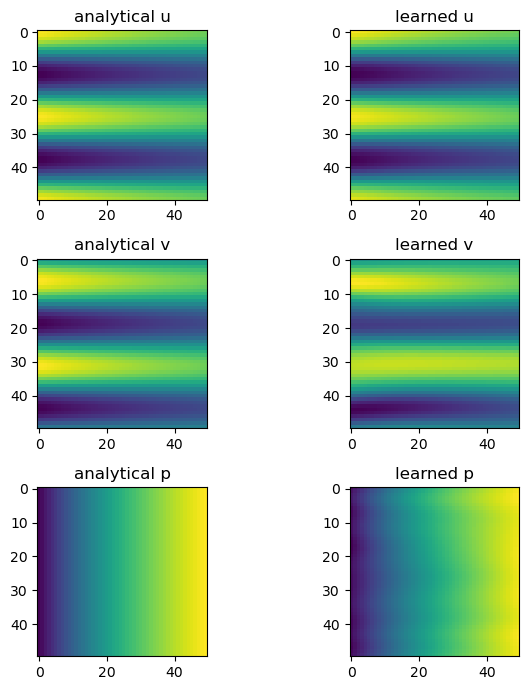

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(7, 7))
axs[0, 0].imshow(u_test)
axs[0, 0].set_title('analytical u')
axs[1, 0].imshow(v_test)
axs[1, 0].set_title('analytical v')
axs[2, 0].imshow(p_test)
axs[2, 0].set_title('analytical p')
axs[0, 1].imshow(u_pred)
axs[0, 1].set_title('learned u')
axs[1, 1].imshow(v_pred)
axs[1, 1].set_title('learned v')
axs[2, 1].imshow(p_pred)
axs[2, 1].set_title('learned p')
fig.tight_layout()

In [13]:
params = pinn.state_dict()
print(params.keys())

odict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'layer3.weight', 'layer3.bias', 'layer4.weight', 'layer4.bias', 'layer5.weight', 'layer5.bias', 'output_layer.weight', 'output_layer.bias'])


In [14]:
flattened_weights = []
for key in params.keys():
    flattened_tensor = torch.reshape(params[key], (-1,)).tolist()
    for val in flattened_tensor:
        flattened_weights.append(val)
weights_array = np.array(flattened_weights)
np.savetxt('data/weights/weights_'+str(Re)+'.txt', weights_array)